In [1]:
import numpy as np
import json
from livecell_tracker.core import (
    SingleCellTrajectory,
    SingleCellStatic,
    SingleCellTrajectoryCollection,
)
from livecell_tracker.segment.detectron_utils import (
    convert_detectron_instance_pred_masks_to_binary_masks,
    convert_detectron_instances_to_label_masks,
    segment_images_by_detectron,
    segment_single_img_by_detectron_wrapper,
)
from livecell_tracker.core.datasets import LiveCellImageDataset
from livecell_tracker.preprocess.utils import (
    overlay,
    enhance_contrast,
    normalize_img_to_uint8,
)
import matplotlib.pyplot as plt
import os
from tqdm import tqdm


/home/ke/anaconda3/envs/livecell/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ke/anaconda3/envs/livecell/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/ke/anaconda3/envs/livecell/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


## Convert Labelme Json to COCO Json

run the following code once for generating coco json
```
import livecell_tracker.segment
import livecell_tracker.annotation
import livecell_tracker.annotation.labelme2coco
import os
labelme_json_folder = r"""../datasets/a549_ccnn/annotation_data"""
dataset_folder_path = r"""../datasets/a549_ccnn/original_data"""
export_dir = "./notebook_results/correction_cnn_v0.0.0/"
os.makedirs(export_dir, exist_ok=True)
livecell_tracker.annotation.labelme2coco.convert(
    labelme_json_folder,
    export_dir,
    train_split_rate=0.9,
    dataset_folder_path=dataset_folder_path,
    # is_image_in_json_folder=True,
    image_file_ext="tif",
    # image_file_ext="png",
)
```

## Load COCO into SingleCell Objects

In [2]:
from pycocotools.coco import COCO

coco_data = COCO("../datasets/a549_ccnn/a549_ccnn_coco_v0.0.0/train.json")

coco_data.anns.keys(), coco_data.anns[1].keys(), coco_data.anns[1]["segmentation"][0][
    :5
]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


(dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 2

In [3]:
coco_data.imgs.keys(), coco_data.imgs[1].keys(), coco_data.imgs[1]["file_name"],


(dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]),
 dict_keys(['height', 'width', 'id', 'file_name']),
 '../datasets/a549_ccnn/original_data/dic_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11/CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T07_XY4_DIC_tile7_DIC-FITC.tif')

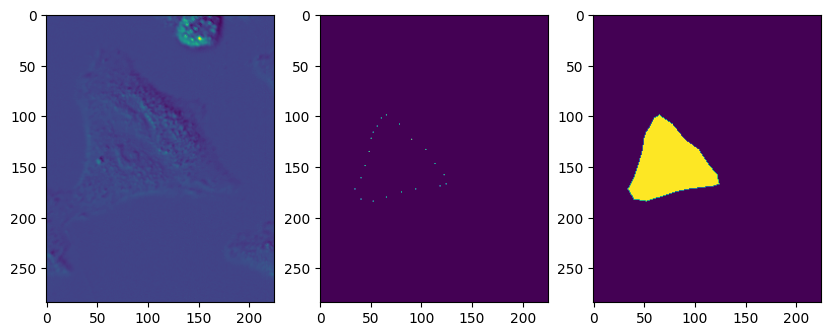

In [4]:
from typing import List

from livecell_tracker.annotation.coco_utils import coco_to_sc

single_cells = coco_to_sc(coco_data)


# for testing
# single_cells = single_cells[:20]

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
cell_id = 10
axes[0].imshow(single_cells[cell_id].get_img_crop(padding=100))
axes[1].imshow(single_cells[cell_id].get_contour_mask_closed_form(padding=100))
axes[2].imshow(single_cells[cell_id].get_contour_mask(padding=100))


In [5]:
len(single_cells)

294

save a list of single cell objects

In [6]:
SingleCellStatic.write_single_cells_json(
    single_cells, "../datasets/a549_ccnn/single_cells.json"
)


In [7]:
contour_mask = single_cells[cell_id].get_contour_mask(padding=100)
contour_mask.astype(np.uint8)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

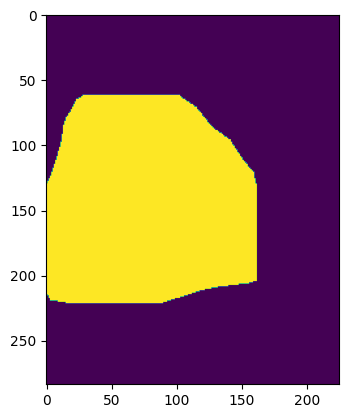

In [8]:
import cv2 as cv
from livecell_tracker.preprocess.utils import dilate_or_erode_mask

plt.imshow(dilate_or_erode_mask(contour_mask.astype(np.uint8), 1))


## Compute similarity between manually segmented cell and segmentation results

We will take sample_sc as an example to show how to compute IOU based similarity between manually segmented cell and segmentation results from machine learning models.  
Instead, this part may be done by a human annotator by clicking the corresponding cell in the segmentation results.

In [9]:
sample_sc = single_cells[cell_id]
sample_sc.meta


{'img_id': 7,
 'path': '../datasets/a549_ccnn/original_data/dic_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11/CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T13_XY1_DIC_tile8_DIC-FITC.tif'}

In [10]:
import glob

raw_img_dataset = sample_sc.img_dataset
seg_data_dir = "../datasets/a549_ccnn/seg_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11"
seg_paths = glob.glob(os.path.join(seg_data_dir, "*.png"))
print("sample seg paths:", seg_paths[:2])
matched_time2seg = {}
# for time, img_path in raw_img_dataset.time2url.items():
#     substr = os.path.basename(img_path).split(".")[0]
#     print("substr:", substr)
#     for seg_path
#     break
corrected_indices = []
for seg_path in seg_paths:
    substr = os.path.basename(seg_path).split(".")[0] # get rid of extension
    substr = substr[4:]  # get rid of seg_ prefix
    img, path, index = raw_img_dataset.get_img_by_url(
        substr, return_path_and_time=True, ignore_missing=True
    )
    if path is None:
        print("skip due to substr not found:", substr)
        continue
    matched_time2seg[index] = seg_path

seg_data = LiveCellImageDataset(time2url=matched_time2seg, ext="png")
sample_sc.mask_dataset = seg_data
assert len(seg_data) == len(raw_img_dataset)


sample seg paths: ['../datasets/a549_ccnn/seg_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11/seg_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T01_XY2_DIC_tile8_DIC-FITC.png', '../datasets/a549_ccnn/seg_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11/seg_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T01_XY5_DIC_tile1_DIC-FITC.png']
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T13_XY1_DIC_tile1_DIC-FITC
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T13_XY2_DIC_tile4_DIC-FITC
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T01_XY1_DIC_tile1_DIC-FITC
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T13_XY3_DIC_tile4_DIC-FITC
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T13_XY4_DIC_tile1_DIC-FITC
skip due to substr not fo

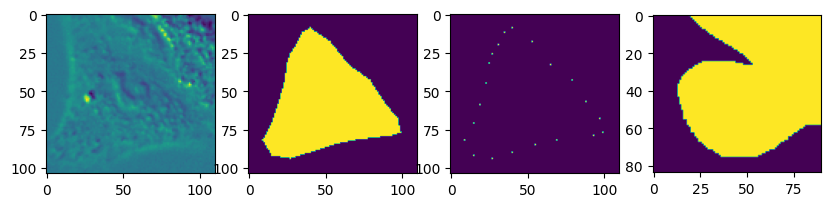

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(10, 5))
axes[0].imshow(sample_sc.get_img_crop(padding=10))
axes[1].imshow(sample_sc.get_contour_mask(padding=10))
axes[2].imshow(sample_sc.get_contour_mask_closed_form(padding=10))
axes[3].imshow(sample_sc.get_mask_crop())


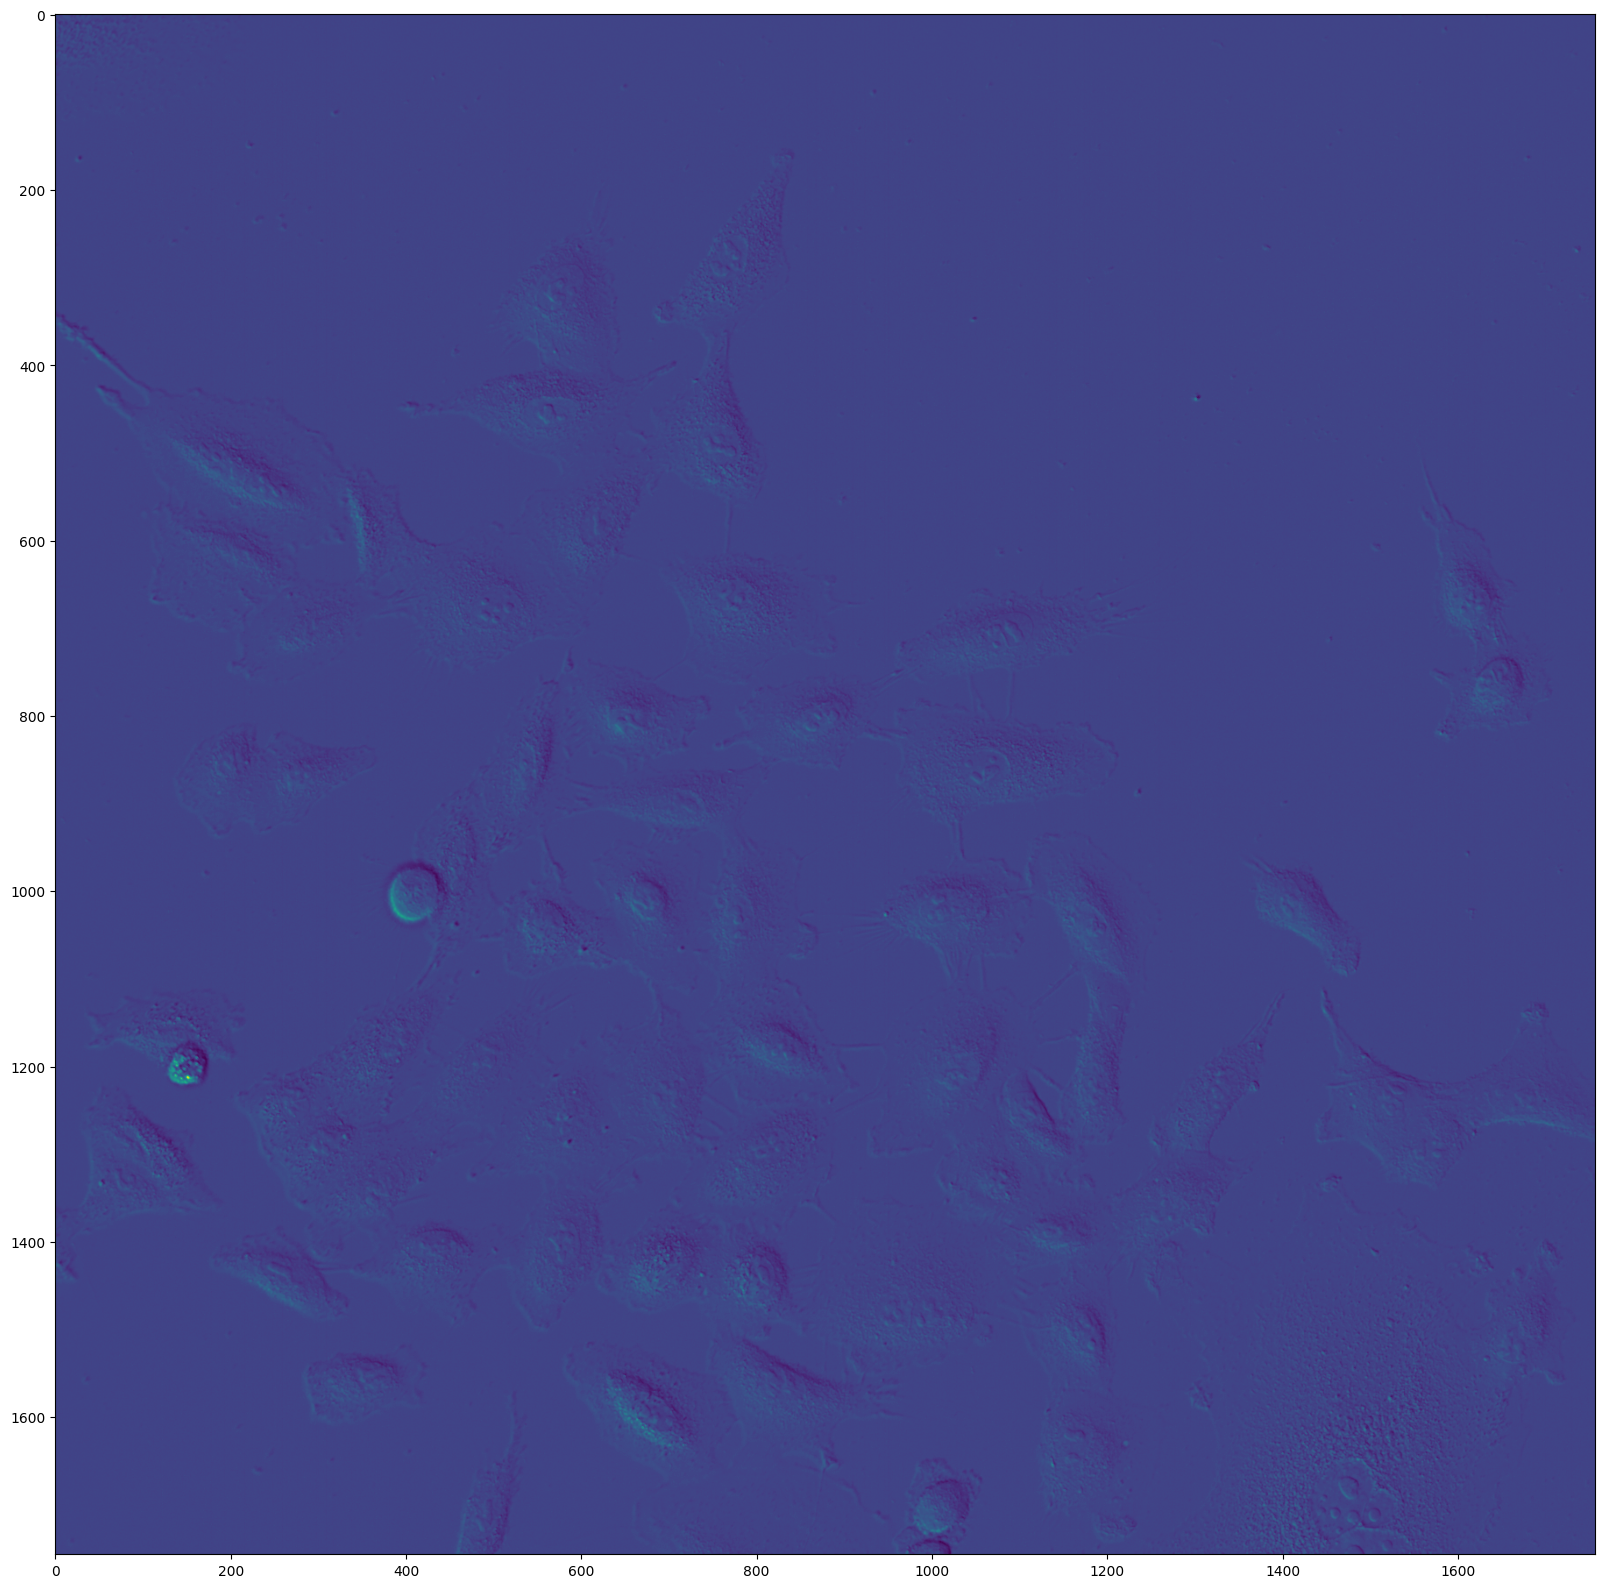

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.imshow(sample_sc.get_img())


In [13]:
seg_mask = seg_data.get_img_by_url(
    os.path.basename(sample_sc.meta["path"]).split(".")[0], substr=True
)


In [14]:
np.max(seg_mask.flatten())


59

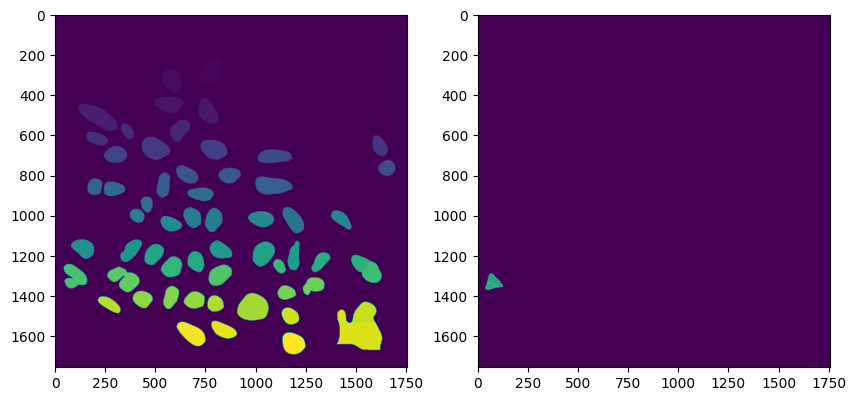

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(seg_mask)
axes[1].imshow(sample_sc.get_contour_img(crop=False))


Text(0.5, 1.0, 'ground truth')

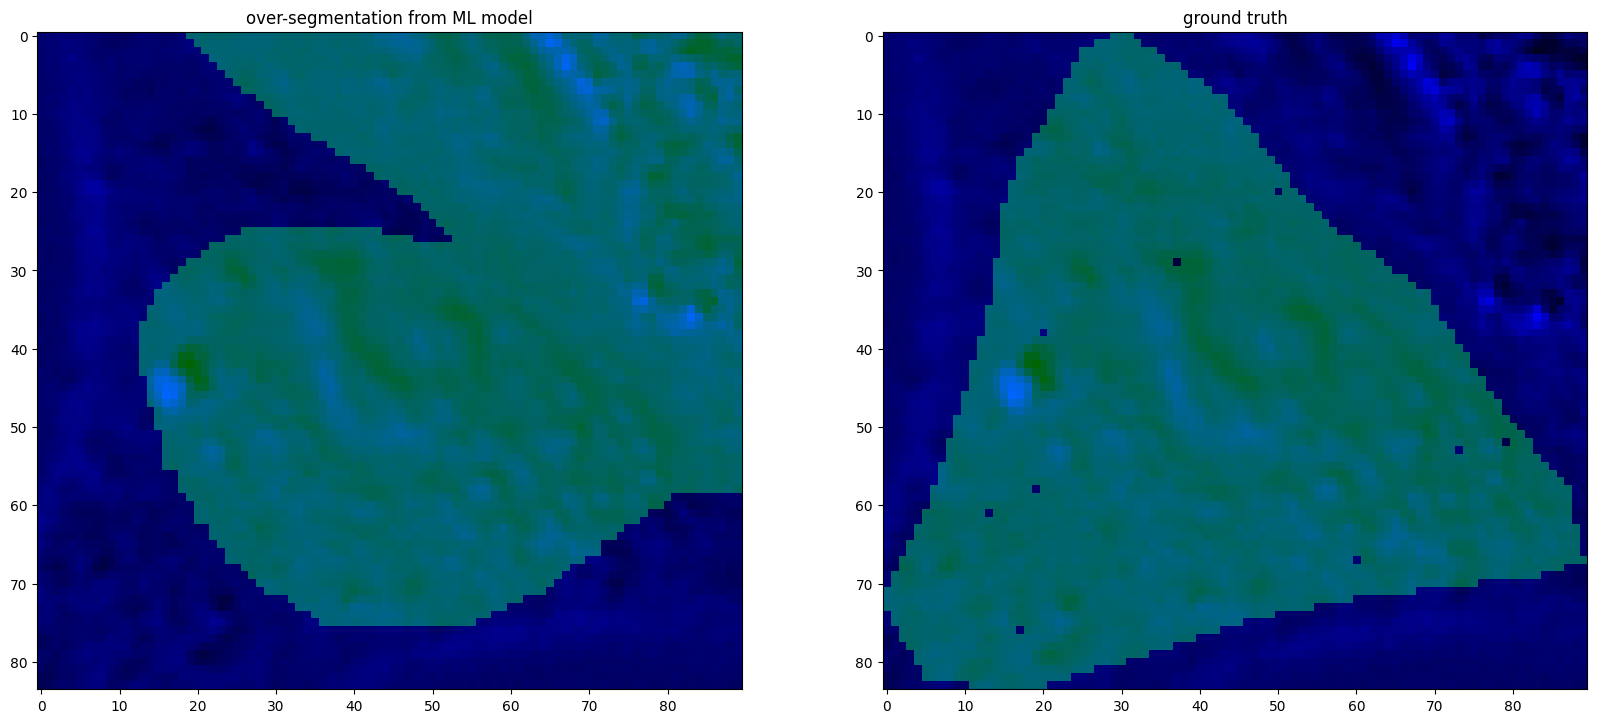

In [16]:
cropped_seg_mask = SingleCellStatic.gen_skimage_bbox_img_crop(sample_sc.bbox, seg_mask)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(
    overlay(sample_sc.get_img_crop(), cropped_seg_mask, img_channel_rgb_val_factor=1)
)
axes[0].set_title("over-segmentation from ML model")
axes[1].imshow(
    overlay(
        sample_sc.get_img_crop(),
        sample_sc.get_contour_img(),
        img_channel_rgb_val_factor=1,
    )
)
axes[1].set_title("ground truth")


In [17]:
from livecell_tracker.segment.utils import match_mask_labels_by_iou

match_mask_labels_by_iou(cropped_seg_mask, sample_sc.get_contour_mask())


{True: {'best_iou': 0.49522693016245184, 'seg_label': 42}}

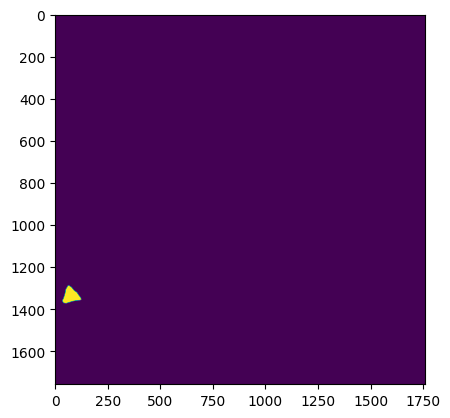

In [18]:
plt.imshow(sample_sc.get_contour_mask(crop=False))


Text(0.5, 1.0, 'T07 XY4 TILE7 seg overlay')

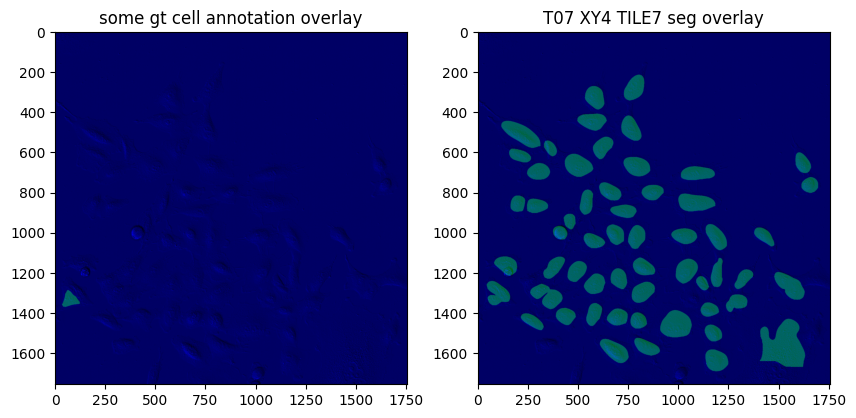

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(
    overlay(
        enhance_contrast(normalize_img_to_uint8(sample_sc.get_img()), factor=0.5),
        sample_sc.get_contour_mask(crop=False),
        img_channel_rgb_val_factor=2,
    )
)
axes[0].set_title("some gt cell annotation overlay")
axes[1].imshow(
    overlay(
        enhance_contrast(normalize_img_to_uint8(sample_sc.get_img()), factor=0.9),
        seg_mask,
        img_channel_rgb_val_factor=2,
    )
)
axes[1].set_title("T07 XY4 TILE7 seg overlay")


In [20]:
sample_sc.get_contour_mask()


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [21]:
def match_seg_mask_label(mask: np.array, sc: SingleCellStatic):
    """find a single cell's label in a mask. sc must contain its contour information."""
    cropped_seg_mask = SingleCellStatic.gen_skimage_bbox_img_crop(sc.bbox, seg_mask)
    match_res = match_mask_labels_by_iou(cropped_seg_mask, sc.get_contour_mask())
    assert len(match_res) == 1, "TODO: bug in match_mask_labels_by_iou"
    match_res = list(match_res.values())[0]
    return match_res


seg_label = match_seg_mask_label(seg_mask, sample_sc)["seg_label"]
seg_label


42

### Compute similarity for all cells and get the mapping between single cells and its corresponding label in the segmentation results

In [22]:
for sc in tqdm(single_cells):
    sc_img_path_substr = os.path.basename(sc.meta["path"]).split(".")[0]
    seg_mask = seg_data.get_img_by_url(sc_img_path_substr, substr=True)
    sc.meta["seg_label"] = match_seg_mask_label(seg_mask, sc)["seg_label"]
    sc.mask_dataset = seg_data


100%|██████████| 294/294 [00:30<00:00,  9.56it/s]


<AxesSubplot: >

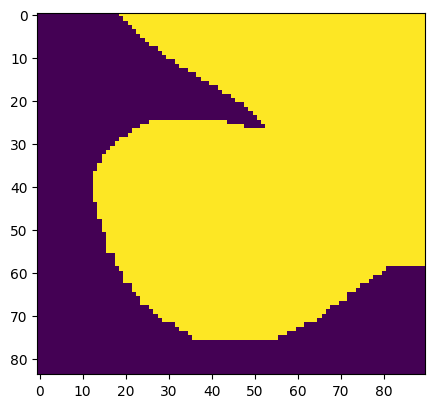

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sample_sc.show_mask()


## Generate dilated and eroded masks for each cell
Create an augmented dataset.
Save results via single cell data structure
```
Single Cell Json metadata
{
    seg_label: 13,
    img_id: 1,
}
```

We pad the each cell mask with a defined background value (0).

In [24]:
len(seg_data), len(sample_sc.img_dataset)


(59, 59)

In [25]:
sample_sc = single_cells[-1]
sample_sc.meta


{'img_id': 59,
 'path': '../datasets/a549_ccnn/original_data/dic_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11/CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T07_XY3_DIC_tile6_DIC-FITC.tif',
 'seg_label': 16}

## Undersegmentation case: create mapping from seg label id to gt id

In [26]:
single_cells[-1].meta, single_cells[-2].meta


({'img_id': 59,
  'path': '../datasets/a549_ccnn/original_data/dic_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11/CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T07_XY3_DIC_tile6_DIC-FITC.tif',
  'seg_label': 16},
 {'img_id': 59,
  'path': '../datasets/a549_ccnn/original_data/dic_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11/CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T07_XY3_DIC_tile6_DIC-FITC.tif',
  'seg_label': 16})

In [27]:
sample_sc.meta


{'img_id': 59,
 'path': '../datasets/a549_ccnn/original_data/dic_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11/CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T07_XY3_DIC_tile6_DIC-FITC.tif',
 'seg_label': 16}

In [28]:
seg2scs = {}
for sc in single_cells:
    seg_label = sc.meta["seg_label"]
    img_id = sc.meta["img_id"]
    key = (img_id, seg_label)
    if key not in seg2scs:
        seg2scs[key] = []
    seg2scs[key].append(sc)


Count how many simple undersegmentation there are in our dataset

In [29]:
underseg_cases = {key: val for key, val in seg2scs.items() if len(val) > 1}
len(underseg_cases)


56

Visualize one such oversegmentation case

In [30]:
# choose any case
underseg_case = list(underseg_cases.items())[2]
underseg_case


((5, 11),
  <livecell_tracker.core.single_cell.SingleCellStatic at 0x7f50259113a0>])

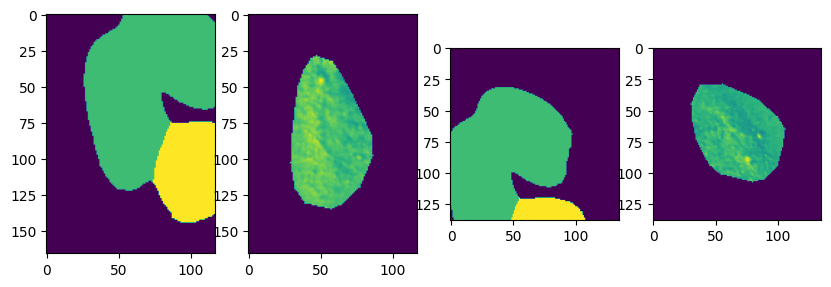

In [31]:
fig, axes = plt.subplots(1, 4, figsize=(10, 5))
underseg_scs = underseg_case[1]
padding = 30
axes[0].imshow(underseg_scs[0].get_mask_crop(padding=padding))
axes[1].imshow(underseg_scs[0].get_contour_img(padding=padding))
axes[2].imshow(underseg_scs[1].get_mask_crop(padding=padding))
axes[3].imshow(underseg_scs[1].get_contour_img(padding=padding))


### Augment undersegmentation case  
sc.mask_dataset, sc.get_mask(): from seg_mask  
sc.bbox, sc.contour, sc.get_contour(): from gt


In [82]:
from pathlib import Path
from typing import Tuple
from skimage.measure import regionprops
import pandas as pd
from livecell_tracker.core.io_utils import save_tiff


def underseg_overlay_gt_masks(
    seg_label: int, scs: SingleCellStatic, padding_scale=1.5, seg_mask=None
) -> Tuple[np.array, np.array, np.array]:
    """Overlay segmentation masks and ground truth masks for under-segmentation cases.
    Specifically, for a segmentation label, if there are multiple ground truth masks matched to it,
    then we overlay ground truths masks in the same kmask

    Parameters
    ----------
    seg_label : int
        _description_
    scs : SingleCellStatic
        _description_
    padding_scale : float, optional
        _description_, by default 1.5
    mask : 
        if not None, use the mask, otherwise inferred from other args, by default None

    Returns
    -------
    Tuple[np.array, np.array, np.array]
        (img_crop, seg_crop, combined ground-truth mask)
    """
    if len(scs) == 0:
        print("no scs for this seg_label")
        return None, None, None

    if seg_mask is None:
        seg_mask = scs[0].get_mask()

    seg_mask[seg_mask != seg_label] = 0
    props_list = regionprops(seg_mask)

    if len(props_list) != 1:
        print(
            "[WARNING] skip: (%d, %d) due to more than one region found in seg mask or NO region found in seg mask"
            % (img_id, seg_label)
        )
        return
    # obtain segmentation bbox from segmentation mask
    seg_props = props_list[0]
    seg_bbox = seg_props.bbox
    xmin, ymin, xmax, ymax = seg_bbox

    # compute padding based on scale
    padding_pixels = np.array((padding_scale - 1) * max(xmax - xmin, ymax - ymin))
    padding_pixels = padding_pixels.astype(int)

    # get seg mask's crop with single cell's get_mask_crop implementation for consistency
    tmp = np.array(scs[0].bbox)
    scs[0].bbox = seg_bbox
    seg_crop = scs[0].get_mask_crop(padding=padding_pixels)
    scs[0].bbox = np.array(tmp)

    # clear other seg labels
    seg_crop[seg_crop != seg_label] = 0
    seg_crop[seg_crop > 0] = 1

    combined_gt_mask = np.zeros(seg_crop.shape)
    img_crop = None
    for idx, sc in enumerate(scs):
        sc.meta["seg_label"] = None
        tmp = np.array(sc.bbox)
        sc.bbox = seg_bbox
        combined_gt_mask += (idx + 1) * sc.get_contour_mask(padding=padding_pixels)
        img_crop = (
            sc.get_img_crop(padding=padding_pixels) if img_crop is None else img_crop
        )  # set img_crop once
        sc.bbox = tmp
    return (img_crop, seg_crop, combined_gt_mask)

def gen_aug_diff_mask(aug_mask:np.array, combined_gt_mask: np.array) -> np.array:
    """generate a mask based on the difference between the augmented mask and the combined gt mask
    0: no difference
    -1: augmented mask is 0, combined gt mask is 1
    1: augmented mask is 1, combined gt mask is 0
    Note: special care for uint8 case when calculating difference mask if we use cv2 related functions

    Parameters
    ----------
    aug_mask : np.array
        _description_
    combined_gt_mask : np.array
        _description_

    Returns
    -------
    np.array
        _description_
    """
    aug_mask = aug_mask.astype(int) # prevent uint8 overflow (-1 in diff case below)
    combined_gt_mask[combined_gt_mask > 0] = 1
    combined_gt_mask = combined_gt_mask.astype(int)
    diff_mask = aug_mask - combined_gt_mask # should only contain 0 and 1
    assert len(np.unique(diff_mask)) <= 3
    
    return diff_mask


underseg_seg2scs = underseg_cases
out_dir = Path("./notebook_results/a549_ccp_vim/train_data_v1/")
raw_out_dir = out_dir / "raw"
seg_out_dir = out_dir / "seg"
gt_out_dir = out_dir / "gt"
augmented_seg_dir = out_dir / "augmented_seg"
os.makedirs(raw_out_dir, exist_ok=True)
os.makedirs(seg_out_dir, exist_ok=True)
os.makedirs(gt_out_dir, exist_ok=True)
os.makedirs(augmented_seg_dir, exist_ok=True)

scale_factors = np.linspace(0, 0.3, 10)

train_path_tuples = []
underseg_seg2masks = {}
for img_id, seg_label in tqdm(underseg_seg2scs):
    scs = underseg_seg2scs[(img_id, seg_label)]
    assert len(scs) > 0, "the list of single cells should not be empty"
    raw_img_path = raw_out_dir / ("img-%d_seg-%d.tif" % (img_id, seg_label))
    seg_img_path = seg_out_dir / ("img-%d_seg-%d.tif" % (img_id, seg_label))
    gt_img_path = gt_out_dir / ("img-%d_seg-%d.tif" % (img_id, seg_label))

    (img_crop, seg_crop, combined_gt_mask) = underseg_overlay_gt_masks(
        seg_label, scs, padding_scale=2
    )
    save_tiff(img_crop, raw_img_path, mode="I")  # save to 32-bit depth signed integer
    save_tiff(seg_crop, seg_img_path)
    save_tiff(combined_gt_mask, gt_img_path)

    # dilate or erode segmentation mask
    for idx, scale in enumerate(scale_factors):
        augmented_seg_path = augmented_seg_dir / (
            "img-%d_seg-%d_aug-%d.tif" % (img_id, seg_label, idx)
        )
        if np.unique(seg_crop).shape[0] > 256:
            print(
                "[WARNING] skip: (%d, %d) due to more than 256 unique seg labels"
                % (img_id, seg_label)
            )
            continue
        seg_crop = seg_crop.astype(np.uint8)


        # seg_crop should only contains one label
        # TODO: the condition above should be a postcondition of underseg_overlay_gt_masks
        seg_crop[seg_crop > 0] = 1 
        aug_seg_crop = dilate_or_erode_mask(seg_crop, scale_factor=scale)
        aug_values = np.unique(aug_seg_crop)
        assert len(aug_values) <= 2, "only two values should be present in aug masks"
        aug_seg_crop[aug_seg_crop > 0] = 1
        aug_seg_crop[aug_seg_crop < 0] = 0 # not necessary, check math
        save_tiff(aug_seg_crop, augmented_seg_path)

        aug_diff_mask = gen_aug_diff_mask(aug_seg_crop, combined_gt_mask)

        train_path_tuples.append(
            (
                raw_img_path.as_posix(),
                augmented_seg_path.as_posix(),
                gt_img_path.as_posix(),
                seg_img_path,
                scale,
                aug_diff_mask
            )
        )
        if (img_id, seg_label) not in underseg_seg2masks:
            underseg_seg2masks[(img_id, seg_label)] = []
        underseg_seg2masks[(img_id, seg_label)].append((img_crop, seg_crop, combined_gt_mask, aug_seg_crop, aug_diff_mask))

    pd.DataFrame(
        train_path_tuples, columns=["raw", "seg", "gt", "raw_seg", "scale", "aug_diff_mask"]
    ).to_csv(out_dir / "train_data.csv", index=False)


100%|██████████| 56/56 [00:21<00:00,  2.59it/s]


In [84]:
(img_crop, seg_crop, combined_mask, aug_mask, aug_diff_mask) = underseg_seg2masks[(1, 14)][0]

In [ ]:
np.unique(combined_mask), np.unique(aug_mask)

(array([0., 1., 2.]), array([0, 1], dtype=uint8))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


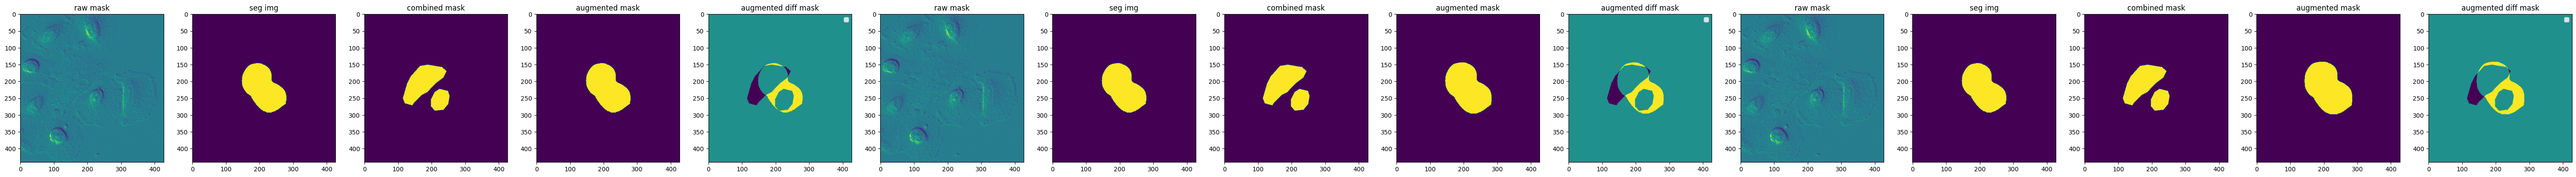

In [87]:
import matplotlib.patches as mpatches

mask_tuples = list(underseg_seg2masks.values())[0]
ncol = 5
fig, axes = plt.subplots(1, 3 * ncol, figsize=(75, 5))
for i in range(3):
    axes[ncol * i].imshow(mask_tuples[i][0])
    axes[ncol * i].set_title("raw mask")
    axes[ncol * i + 1].imshow(mask_tuples[i][1])
    axes[ncol * i + 1].set_title("seg img")
    axes[ncol * i + 2].imshow(mask_tuples[i][2])
    axes[ncol * i + 2].set_title("combined mask")
    axes[ncol * i + 3].imshow(mask_tuples[i][3])
    axes[ncol * i + 3].set_title("augmented mask")
    im = axes[ncol * i + 4].imshow(mask_tuples[i][4])
    axes[ncol * i + 4].set_title("augmented diff mask")

    values = np.unique(mask_tuples[i][4])
    colors = [ im.cmap(im.norm(value)) for value in values]
    patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values)) ]
    axes[ncol * i + 4].legend()



Deprecated code for augmenting a single cell for CSN
```
from pathlib import Path
from copy import deepcopy
from PIL import Image, ImageSequence

img_paths = []
augment_dir = Path("../datasets/a549_ccnn/augmented_cells")
augmented_cells = []
scale_factor = 0.01
padding = 100

def augment_single_cell_csn(sc: SingleCellStatic, augment_dir: Path, scale_factor=0.01, padding=40, show=False, bg_value=0):
    mask = sc.get_mask_crop(padding=padding).astype(np.uint8)
    mask_label = sc.meta["seg_label"]
    mask[mask!=mask_label] = bg_value

    augmented_mask = dilate_or_erode_mask(mask, scale_factor=scale_factor)
    augmentation_save_path = augment_dir / f"{i}_mask.tif"
    save_png(augmented_mask, str(augmentation_save_path))

    meta = {}
    meta["original_path"] = sc.meta["path"]
    meta["original_seg_label"] = sc.meta["seg_label"]
    meta["path"] = augmentation_save_path.as_posix()
    meta["padding"] = padding
    meta["scale_factor"] = scale_factor
    meta["method"] = "dilate/erode"

    new_sc = SingleCellStatic(
        img_dataset=sc.img_dataset,
        mask_dataset=sc.mask_dataset,
        contour = np.array(sc.contour),
        meta=meta,
    )

    if show:
        fig, axes = plt.subplots(1, 4, figsize=(10, 10))
        # sc.show_mask(ax=axes[0])
        sc.show(ax=axes[0])
        axes[2].imshow(mask)
        sc.show_contour_img(ax=axes[1])
        axes[3].imshow(augmented_mask)

        axes[0].set_title("original image crop")
        axes[2].set_title("seg mask")
        axes[1].set_title("gt contour mask")
        axes[3].set_title("augmented mask")
    return new_sc


augmented_single_cells = []
for i in tqdm(range(len(single_cells))):
    sc = single_cells[i]
    augmented_sc = augment_single_cell_csn(sc, augment_dir, scale_factor=scale_factor, padding=padding, show=False)
    augmented_single_cells.append(augmented_sc)
```


Undersegmentation case:
    overlay all the ground truth masks on the original image, and then use the result as the ground truth mask for the undersegmentation case.
    Segmentation mask 
    gt mask

OVERSEGMENTATION CASE:
    # future work
    Segmentation mask
    gt mask


1. Overlay segmentation mask and gt mask
2. Shift the cells in the segmentation mask to the center of the cell
3. Synthetic dataset

thin_plate_spline?